# Data Download

In [1]:
from Korpora import Korpora
import pickle

In [2]:
# Korpora.fetch('namuwikitext')

In [3]:
# corpus = Korpora.load('namuwikitext')
# with open('kor.p', 'wb') as f:
#     pickle.dump(corpus, f)

In [4]:
with open('kor.p', 'rb') as f:
    corpus = pickle.load(f)

# data preprocess

In [5]:
import mecab
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import torchtext
import sys
sys.path.append('../source')
from txt_cleaner.clean.master import MasterCleaner
from txt_cleaner.utils import *
from torch8text.data import Vocab, Field

## field 1: mecab 사용 field

In [6]:
pos = mecab.MeCab()

def tokenize_pos(inp):
    if type(inp) == str:
        return pos.morphs(inp)
    if type(inp) == list:
        return [tokenize_pos(i) for i in inp]
# pos.morphs(['안녕하세요'])

In [7]:
tokenize_pos('안녕하세요'), tokenize_pos(['안녕하세요', '안녕?'])

(['안녕', '하', '세요'], [['안녕', '하', '세요'], ['안녕', '?']])

### 수인님 cleaner 

In [8]:
config = json_reader('../source/txt_cleaner/cleaner_config.json')

size 1 dictionary is read from ../source/txt_cleaner/cleaner_config.json


In [9]:
config['minimum_space_count'] = 2
config

{'minimum_space_count': 2}

In [10]:
cleaner = MasterCleaner(config)
cleaner.cleaning('안녕하세요? 반갑습니다! 행복하세요~**')

'안녕하세요? 반갑습니다! 행복하세요'

In [11]:
tokenize_pos(['안녕하세요', '안녕'])

[['안녕', '하', '세요'], ['안녕']]

In [12]:
mecab_field = Field(tokenize = tokenize_pos, 
                 preprocessing = cleaner.cleaning,
                    init_token = False,
                    eos_token = False
                )

In [13]:
train = [text for text in corpus.train.texts if text]
mecab_field.build_vocab(train)
mecab_field.preprocess('안녕하세요 룰루랄라 ㅇㅇㄹ')

['안녕', '하', '세요', '룰루랄라']

## field 2:  chr-level field

In [14]:
cleaner.cleaning('아')

''

In [15]:
cleaner = MasterCleaner({'minimum_space_count':0})
chr_field = Field(tokenize = list, 
                 preprocessing = lambda e: cleaner.cleaning(e) if len(e) > 1 else e,
                  init_token = False,
                  eos_token = False,
                )

In [16]:
chr_field.build_vocab(train)

## 토큰별로 한번, 토큰 내 캐릭터 레벨로 한번 데이터셋을 구성해야 함 
-> 토큰에서 unk이면 어차피 chr level도 unk이기 때문에 {토큰 idx: 캐릭터 idx 리스트} 딕셔너리를 만들면 쉽지 않을까? 

In [17]:
for key, value in mecab_field.vocab.stoi_dict.items():
    print(value)
    break

0


In [18]:
mecab_field.vocab.special_tokens

['<UNK>', '<PAD>', '<SOS>', '<EOS>']

In [19]:
chr_dict = {key: chr_field.process(value) 
            if value not in mecab_field.vocab.special_tokens
            else [0]
            for key, value in mecab_field.vocab.itos_dict.items() 
             }

In [20]:
mecab_field.vocab.itos_dict[78], chr_field.vocab.itos_dict[160], chr_field.vocab.itos_dict[188]

('Up', 'U', 'p')

# dataset, dataloader
## 헷갈리는 부분
bi-directional LSTM을 쓸건데 이게 다음 단어 예측하는 LM만 데이터를 구성하면 되나? 아니면 뒤에서부터 앞의 단어를 예측하는 LM도 구성해서 concat해야 하나? -> 일단 전자라고 생각하고 함

In [21]:
from collections import namedtuple  
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class ELMoDataset(Dataset):
    def __init__(self, src, field):
        self.src = src
        self.field = field
        self.named_tuple = namedtuple('data', ['src', 'trg'])
        
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.named_tuple(self.getitem(idx), self.getitem(idx)[1:])
    
    def getitem(self, idx):
        data = self.src[idx]
        tokenize_data = self.field.preprocess(data)
        return torch.Tensor(self.field.vocab.stoi(tokenize_data)).long()

In [22]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [23]:
ds = ELMoDataset(train, mecab_field)

In [24]:
for _ in ds:
    print(_.src)
    print(_.trg)
    break

tensor([1695,    8, 1066,    8, 1696,   94,  248,  313,   19,    6, 1697,    8,
        1698,    9, 1699, 1700,  517,  112,   12,    4, 1701, 1067,    7,  518,
        1702,    8, 1068,   13,  629,   18, 1703,  112,  150,   10,   85, 1069,
          37,  189, 1704,    7, 1705,   10,  165,   21,  447,   22, 1068,   14,
        1706, 1070,   17, 1707,    9, 1708,    4,  783, 1066,  223,   20,   21,
          29,    6,   27,  379,   13, 1709,   79,   18, 1710, 1069,   18,    6,
         630,    8, 1071,    7, 1711,    4,  278,  249,    5,   96,  631,    5,
         106, 1712,   35, 1072, 1713,  314,   47,  113,   24,  448,   74, 1714,
          10,   12,    4,   32, 1715,    9, 1716,  250,   35, 1717,  250, 1073,
           8,  519,   19, 1074,  128,   10,  380,   31,   21, 1718,   54,   60,
          22,  381,    4])
tensor([   8, 1066,    8, 1696,   94,  248,  313,   19,    6, 1697,    8, 1698,
           9, 1699, 1700,  517,  112,   12,    4, 1701, 1067,    7,  518, 1702,
           8,

In [25]:
def pad_collate(batch):
    (src, trg) = zip(*batch)
    named_tuple = namedtuple('data', ['src', 'trg'])
    src_pad = pad_sequence(src, batch_first=True, padding_value=0)
    trg_pad = pad_sequence(trg, batch_first=True, padding_value=0)
    return named_tuple(src_pad, trg_pad)

In [26]:
# def pack_pad_collate(batch):
#     (src, trg) = zip(*batch)
#     src_len = torch.Tensor([len(s) for s in src])
#     trg_len = torch.Tensor([len(t) for t in trg])
#     named_tuple = namedtuple('data', ['src', 'trg'])
#     src_pad = pad_sequence(src, batch_first=True, padding_value=0)
#     trg_pad = pad_sequence(trg, batch_first=True, padding_value=0)
#     src_pack = pack_padded_sequence(src_pad, lengths=src_len, batch_first=True, enforce_sorted=False)
#     trg_pack = pack_padded_sequence(trg_pad, lengths=trg_len, batch_first=True, enforce_sorted=False)
#     return named_tuple(src_pack, trg_pack)

In [27]:
dl = DataLoader(ds, batch_size = 16, collate_fn = pad_collate)
for _ in dl:
    print(_.src.data)
    print(_.trg.data)
    break

tensor([[1695,    8, 1066,  ...,    0,    0,    0],
        [1719, 1075, 1720,  ...,    0,    0,    0],
        [ 647,  648,   17,  ...,    0,    0,    0],
        ...,
        [2045,    8, 2046,  ...,    0,    0,    0],
        [2068,   66,   65,  ...,    0,    0,    0],
        [ 402,  688,   18,  ...,    0,    0,    0]])
tensor([[   8, 1066,    8,  ...,    0,    0,    0],
        [1075, 1720,  154,  ...,    0,    0,    0],
        [ 648,   17, 1108,  ...,    0,    0,    0],
        ...,
        [   8, 2046, 2047,  ...,    0,    0,    0],
        [  66,   65,  104,  ...,    0,    0,    0],
        [ 688,   18,   32,  ...,    0,    0,    0]])


In [28]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim)) 
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))

        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
#         print('embedded shape', embedded.shape) 
        embedded = embedded.unsqueeze(0)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [29]:
VOCAB_SIZE = len(chr_field.vocab)
EMBEDDING_DIM = 1024
N_FILTERS = 1
FILTER_SIZES = (1, 2)
PAD_IDX = chr_field.vocab.stoi_dict['<PAD>']
SPECIAL_TOKENS = chr_field.vocab.special_tokens
SPECIAL_TOKENS_INDEX = chr_field.vocab.special_tokens_idx
CHR_DICT = chr_dict
OUTPUT_DIM = 1024
DROPOUT = 0.5

In [30]:
cnn = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [31]:
class LSTM_LM(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.num_dircetions = 2 if bidirectional else 1
        
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout, bidirectional = bidirectional)
        
        self.fc_out = nn.Linear(hid_dim * self.num_dircetions, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def init_hidden(self):
        # (num_layers * num_directions, batch, hidden_size)
        return torch.zeros(self.n_layers * self.num_dircetions, 1, self.hid_dim)
    
    def forward(self, input):
#         print(f'input shape : {input.shape}') # seqlen, batch, hid_dim(output_dim of cnn)
        output, (hidden, cell) = self.rnn(input)
#         print(f'output shape : {output.shape}') # ouput shape :(seq_len, batch, num_directions * hidden_size)  
        
        prediction = self.fc_out(output)
#         print(f'prediction shape {prediction.shape}') # seq len, batchsize, trg_dim
        return prediction, hidden, cell

In [32]:
OUTPUT_DIM

1024

In [33]:
INPUT_DIM = OUTPUT_DIM
PREDICT_DIM = len(mecab_field.vocab)
HID_DIM = 1024
N_LAYERS = 2
DROPOUT = 0.5
BIDIRECTIONAL = True
TRG_PAD_IDX = mecab_field.vocab.stoi_dict['<PAD>']

In [34]:
rnn = LSTM_LM(INPUT_DIM, PREDICT_DIM, HID_DIM, N_LAYERS, DROPOUT, BIDIRECTIONAL)

In [35]:
rnn

LSTM_LM(
  (rnn): LSTM(1024, 1024, num_layers=2, dropout=0.5, bidirectional=True)
  (fc_out): Linear(in_features=2048, out_features=3973, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

`<sos>`토큰이랑 `<eos>` 토큰은 어떻게 CNN처리 해야하지?  -> 일단 빼는걸로 처리

## 한글이랑 영어랑 다른점 : 영어는 3char이하인 단어가 별로 없는데 한글은 1~2개로 많이 끊겨서 conv연산 하기가 애매함 

In [36]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
import torch.optim as optim

optimizer = optim.Adam(cnn.parameters(), lr=0.0005)

In [43]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [44]:
cnn.apply(initialize_weights);
rnn.apply(initialize_weights);

In [45]:
epoch_loss = []
n_pass = 0
for epoch in range():
    optimizer.zero_grad()
    for src, trg in dl: 
        for idx, token in enumerate(src): # for one batch
            inputs = [torch.tensor(chr_dict[int(t)]) for t in token]
            try:
                features = torch.cat([cnn(input) for input in inputs if input.shape[0] >1], axis=0)         # cnn으로 뽑은 feature의 모음
                output, hidden, cell = rnn(features.unsqueeze(1))
                target = trg[idx][:len(output)]
                loss = criterion(output.squeeze(1), target)
                loss.backward()
                optimizer.step()
                epoch_loss += [loss.item()]
            except Exception as e: # 글자가 1개 짜리인 거밖에 없을 때
                n_pass += 1
                pass

In [47]:
import matplotlib.pyplot as plt

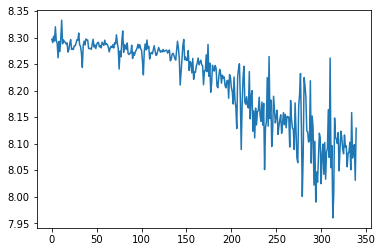

In [50]:
plt.plot(epoch_loss)

# 해야 할 일 : 1) for 문 안돌고 배치 처리할 수 있게 하기 2) CNN + RNN 감싸기